In [1]:
from math import pi
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd.functional import jacobian
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

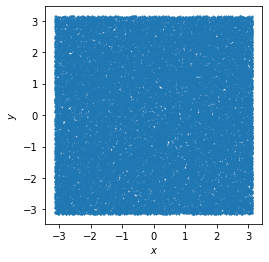

In [98]:
# The first step in learning a neural certificate is to define the dynamics and build a dataset.

# Let's define the dynamics in closed-loop form for now (potentially revisit control-affine later)
n_states = 3
n_controls = 1
def dynamics_fn(x, u):
    """Fixed-speed dubins car dynamics"""
    theta = x[:, 2]
    steering_rate = u[:, 0]
    
    v = 1.0

    x_velocity = v * torch.cos(theta)
    y_velocity = v * torch.sin(theta)
    
    xdot = torch.zeros_like(x)
    xdot[:, 0] = x_velocity
    xdot[:, 1] = y_velocity
    xdot[:, 2] = steering_rate
    
    return xdot

# We also need a function for replacing theta with its sine and cosine
def nn_input(x):
    nn_input = torch.zeros(x.shape[0], n_states + 1)
    nn_input[:, :2] = x[:, :2]
    nn_input[:, 2] = torch.sin(x[:, 2])
    nn_input[:, 3] = torch.cos(x[:, 2])
    
    return nn_input

# We can build a dataset in the simplest possible way by randomly sampling a bunch of points
n_train = int(5e4)
x_train = torch.Tensor(n_train, n_states).uniform_(-pi, pi)

# We can plot the dataset to make sure we have good coverage (this is less helpful in higher dimensions)
plt.scatter(x_train[:, 0], x_train[:, 1], s=1.0)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.gca().set_aspect("equal")

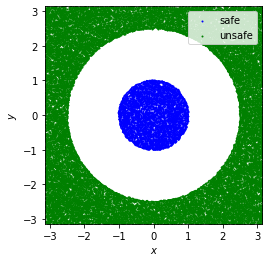

In [100]:
# For a barrier function, we need to define the safe and unsafe regions, which we can do using these functions
# that label points in the state space as safe or unsafe
r_outer = 1.0
buffer = 1.5

def safe_mask(x):
    # Let's define a safe zone
    r_squared = x[:, 0] ** 2 + x[:, 1] ** 2
    return r_squared <= r_outer ** 2

def unsafe_mask(x):
    # Everything outside the safe region (and some buffer) is unsafe
    r_squared = x[:, 0] ** 2 + x[:, 1] ** 2
    return r_squared >= (r_outer + buffer) ** 2


# Let's plot these to make sure we got it right
plt.scatter(x_train[safe_mask(x_train), 0], x_train[safe_mask(x_train), 1], s=1.0, c="b", label="safe")
plt.scatter(x_train[unsafe_mask(x_train), 0], x_train[unsafe_mask(x_train), 1], s=1.0, c="g", label="unsafe")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend(loc="upper right")
plt.gca().set_aspect("equal")

# It will be convenient to define a function to plot an overlay of the safe/unsafe regions
def plot_safe_unsafe_boundary(ax):
    ax.plot([], [], "b", label="Safe region boundary")
    ax.plot([], [], "g", label="Unsafe region boundary")
    ax.tricontour(x_train[:, 0], x_train[:, 1], safe_mask(x_train), levels=[0.5], colors=["b"])
    ax.tricontour(x_train[:, 0], x_train[:, 1], unsafe_mask(x_train), levels=[0.5], colors=["g"])

plot_safe_unsafe_boundary(plt.gca())

/tmp/ipykernel_3113466/536257416.py:62: UserWarning: No contour levels were found within the data range.
  plt.tricontour(x_slice[:, 0], x_slice[:, 1], barrier_nn(nn_input(x_slice)), levels=[0.0], colors=["r"])


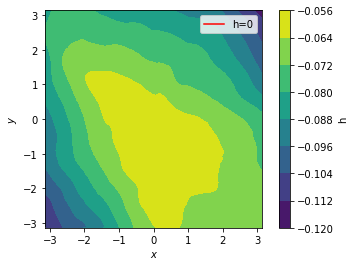

In [115]:
# Now we need to learn both a controller and a barrier function
# You could also learn a CBF and derive the controller using a QP,
# but that involves a bit more plumbing that I'll add later.

# Let's define both of these as neural networks. Unlike the Lyapunov function, which has
# a quadratic prior, we don't have a good prior structure for the barrier function, so
# we'll just use a standard neural net.
class BarrierNN(torch.nn.Module):
    def __init__(
        self,
        hidden_layers: int,
        hidden_layer_width: int,
        n_states: int,
    ):
        """
        A model for learning a barrier function.
        
        We'll learn the barrier function as the output of a neural network

        args:
            hidden_layers: how many hidden layers to have
            hidden_layer_width: how many neurons per hidden layer
            n_states: how many input state dimensions
        """
        super(BarrierNN, self).__init__()

        # Construct the network
        self.layers = OrderedDict()
        self.layers["input_linear"] = nn.Linear(
            n_states,
            hidden_layer_width,
        )
        for i in range(hidden_layers):
            self.layers[f"layer_{i}_activation"] = nn.ReLU()
            self.layers[f"layer_{i}_linear"] = nn.Linear(
                hidden_layer_width, hidden_layer_width
            )
        self.layers["output_activation"] = nn.ReLU()
        self.layers["output_linear"] = nn.Linear(
            hidden_layer_width, 1
        )
        self.layers["output_activation_2"] = nn.Tanh()
        self.nn = nn.Sequential(self.layers)

    def forward(self, x: torch.Tensor):
        h = self.nn(x)  # batch size x 1
        return h.squeeze()
    
# Make the barrier network. Needs 1 extra state for the sine and cosine of theta
barrier_nn = BarrierNN(3, 128, n_states + 1)

# This will be randomly initialized, but we can still plot it!
with torch.no_grad():  # no gradient needed for plotting
    # Instead of projecting all of our data into the xy plane, let's take a slice with
    # theta = 0
    x_slice = x_train.clone()
    x_slice[:, 2] = 0.0
    plt.tricontourf(x_slice[:, 0], x_slice[:, 1], barrier_nn(nn_input(x_slice)))
    plt.colorbar(label="h")
    plt.plot([], [], c="r", label="h=0")
    plt.tricontour(x_slice[:, 0], x_slice[:, 1], barrier_nn(nn_input(x_slice)), levels=[0.0], colors=["r"])
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")
    plt.legend()
    plt.gca().set_aspect("equal")

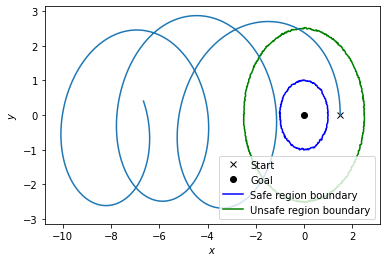

In [116]:
# Now we can define a policy network in a similar way
class ControlNN(torch.nn.Module):
    def __init__(
        self,
        hidden_layers: int,
        hidden_layer_width: int,
        n_states: int,
        n_controls: int,
    ):
        """
        A model for learning a control policy.

        args:
            hidden_layers: how many hidden layers to have
            hidden_layer_width: how many neurons per hidden layer
            n_states: how many input state dimensions
            n_controls: how many output control dimensions
        """
        super(ControlNN, self).__init__()


        # Construct the network
        self.layers = OrderedDict()
        self.layers["input_linear"] = nn.Linear(
            n_states,
            hidden_layer_width,
        )
        self.layers["input_activation"] = nn.ReLU()
        for i in range(hidden_layers):
            self.layers[f"layer_{i}_linear"] = nn.Linear(
                hidden_layer_width, hidden_layer_width
            )
            self.layers[f"layer_{i}_activation"] = nn.ReLU()
        self.layers["output_linear"] = nn.Linear(
            hidden_layer_width, n_controls
        )
        self.layers[f"output_activation"] = nn.Tanh()
        self.nn = nn.Sequential(self.layers)

    def forward(self, x: torch.Tensor):
        u = self.nn(x)  # batch size x n_controls
        # Scale up to get some more control authority
        u = 5 * u
        return u

# Make the control network
# Add one dimension to the states for the sine and cosine
control_nn = ControlNN(3, 64, n_states + 1, n_controls)

# This will be randomly initialized, and so it will likely not contol the system very well,
# but that won't stop us from trying!
with torch.no_grad():  # no gradient needed for simulation/plotting
    dt = 0.05
    n_steps = 1000
    x_sim = torch.zeros((n_steps, n_states))
    x_sim[0, :] = torch.tensor([1.5, 0.0, pi / 2])
    for tstep in range(1, n_steps):
        x_current = x_sim[tstep - 1, :].reshape(1, n_states)
        u = control_nn(nn_input(x_current))
        xdot = dynamics_fn(x_current, u)
        x_sim[tstep, :] = x_current + dt * xdot

    plt.plot(x_sim[0, 0], x_sim[0, 1], "kx", label="Start")
    plt.plot(0, 0, "ko", label="Goal")
    plt.plot(x_sim[:, 0], x_sim[:, 1])
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")
    plot_safe_unsafe_boundary(plt.gca())
    plt.legend()

KeyboardInterrupt: 

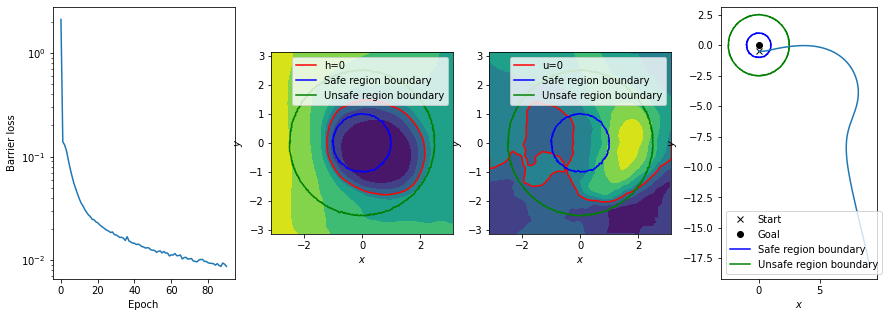

In [117]:
# Not great, but we can do better!

# The next step is to define the loss that let's us refine our barrier function and
# controller to be safe. We need three terms in our loss function here: two will train
# the barrier function to recognize the safe and unsafe regions, and the third will
# train the barrier function and controller to satisfy the barrier function's
# derivative requirement.

# Let's define a barrier function to be negative in the safe region and positive
# in the unsafe region, then the derivative constraint is dh/dt <= -alpha * h

def barrier_loss(x, u):
    loss = torch.tensor(0.0)
    
    # Convert input
    nn_in = nn_input(x)
    
    # Typically we need a larger weight on the boundary terms
    boundary_weight = 1e1
    
    # The barrier function should be negative in the safe region
    margin = 0.2
    loss += boundary_weight * F.relu(margin + barrier_nn(nn_in[safe_mask(x)])).mean()
    
    # And positive in the unsafe region
    loss += boundary_weight * F.relu(margin - barrier_nn(nn_in[unsafe_mask(x)])).mean()
    
    # The barrier function should have "sufficiently negative" derivative
    # Use a numerical approximation of the derivative
    h_now = barrier_nn(nn_in)
    dt = 0.1
    x_next = torch.zeros_like(x) + x
    # It's important to integrate here over multiple substeps so control actions
    # have some time to take effect
    substeps = 10
    for _ in range(substeps):
        x_next = x_next + dt / substeps * dynamics_fn(x_next, u)
    h_next = barrier_nn(nn_input(x_next))
    dh_dt = (h_next - h_now) / dt
    
    barrier_alpha = 0.1  # governs the allowable rate of change
    margin = 0.1
    loss += F.relu(margin + dh_dt + barrier_alpha * h_now).mean()
    
    # Add a final small term to encourage small control outputs
    loss += 1e-2 * (u ** 2).sum(dim=-1).mean()
    
    return loss
    
# Now we can do training!
learning_rate = 1e-4
optimizer = torch.optim.Adam(
    list(barrier_nn.parameters()) + list(control_nn.parameters()),
    lr=learning_rate
)

n_epochs = 200  # run through the dataset this many times
batch_size = 512  # how many points to evaluate at a time
losses = []
fig, axs = plt.subplots(1, 3)
for epoch in range(n_epochs + 1):
    permutation = torch.randperm(n_train)

    loss_accumulated = 0.0
    epoch_range = range(0, n_train, batch_size)
    for i in epoch_range:
        batch_indices = permutation[i : i + batch_size]
        x_batch = x_train[batch_indices]

        # Forward pass: predict the control input and get the barrier loss
        u = control_nn(nn_input(x_batch))
        loss = barrier_loss(x_batch, u)

        # Compute backpropagate and step the optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate the loss for logging
        loss_accumulated += loss.detach()

    losses.append(loss_accumulated / (n_train / batch_size))
    
    if epoch % 10 == 0:
        with torch.no_grad():
            plt.close(fig)
            fig, axs = plt.subplots(1, 4, figsize=(15, 5))

            axs[0].semilogy(losses)
            axs[0].set_ylabel("Barrier loss")
            axs[0].set_xlabel("Epoch")

            x_slice[:, 2] = 0  # slice at this theta
            axs[1].tricontourf(x_slice[:, 0], x_slice[:, 1], barrier_nn(nn_input(x_slice)))
            axs[1].plot([], [], c="r", label="h=0")
            axs[1].tricontour(x_slice[:, 0], x_slice[:, 1], barrier_nn(nn_input(x_slice)), levels=[0.0], colors=["r"])
            axs[1].set_xlabel(r"$x$")
            axs[1].set_ylabel(r"$y$")
            plot_safe_unsafe_boundary(axs[1])
            axs[1].legend()
            axs[1].set_aspect("equal")
            
            axs[2].tricontourf(x_slice[:, 0], x_slice[:, 1], control_nn(nn_input(x_slice)).squeeze())
            axs[2].plot([], [], c="r", label="u=0")
            axs[2].tricontour(x_slice[:, 0], x_slice[:, 1], control_nn(nn_input(x_slice)).squeeze(), levels=[0.0], colors=["r"])
            axs[2].set_xlabel(r"$x$")
            axs[2].set_ylabel(r"$y$")
            plot_safe_unsafe_boundary(axs[2])
            axs[2].legend()
            axs[2].set_aspect("equal")
            
            dt = 0.05
            n_steps = 500
            x_sim = torch.zeros((n_steps, n_states))
            x_sim[0, :] = torch.tensor([0.0, -0.5, 0.0])
            for tstep in range(1, n_steps):
                x_current = x_sim[tstep - 1, :].reshape(1, n_states)
                u = control_nn(nn_input(x_current))
                xdot = dynamics_fn(x_current, u)
                x_sim[tstep, :] = x_current + dt * xdot

            axs[3].plot(x_sim[0, 0], x_sim[0, 1], "kx", label="Start")
            axs[3].plot(0, 0, "ko", label="Goal")
            axs[3].plot(x_sim[:, 0], x_sim[:, 1])
            axs[3].set_xlabel(r"$x$")
            axs[3].set_ylabel(r"$y$")
            plot_safe_unsafe_boundary(axs[3])
            axs[3].legend()
            axs[3].set_aspect("equal")

            display.display(fig)
            display.clear_output(wait=True)

In [24]:
# Eyyyy!

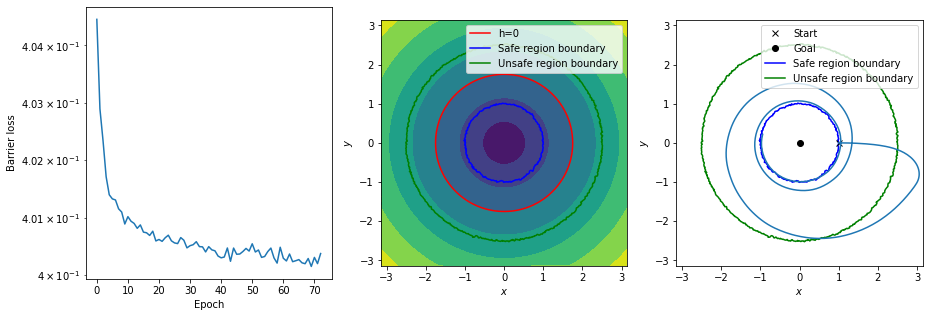

In [112]:
with torch.no_grad():
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].semilogy(losses)
    axs[0].set_ylabel("Barrier loss")
    axs[0].set_xlabel("Epoch")

    x_slice[:, 2] = pi/2  # slice at this theta
    axs[1].tricontourf(x_slice[:, 0], x_slice[:, 1], barrier_nn(nn_input(x_slice)))
    axs[1].plot([], [], c="r", label="h=0")
    axs[1].tricontour(x_slice[:, 0], x_slice[:, 1], barrier_nn(nn_input(x_slice)), levels=[0.0], colors=["r"])
    axs[1].set_xlabel(r"$x$")
    axs[1].set_ylabel(r"$y$")
    plot_safe_unsafe_boundary(axs[1])
    axs[1].legend()
    axs[1].set_aspect("equal")
    
#     axs[2].tricontourf(x_slice[:, 0], x_slice[:, 1], control_nn(nn_input(x_slice)).squeeze())
#     axs[2].plot([], [], c="r", label="u=0")
#     axs[2].tricontour(x_slice[:, 0], x_slice[:, 1], control_nn(nn_input(x_slice)).squeeze(), levels=[0.0], colors=["r"])
#     axs[2].set_xlabel(r"$x$")
#     axs[2].set_ylabel(r"$y$")
#     plot_safe_unsafe_boundary(axs[2])
#     axs[2].legend()
#     axs[2].set_aspect("equal")

    dt = 0.05
    n_steps = 500
    x_sim = torch.zeros((n_steps, n_states))
    x_sim[0, :] = torch.tensor([1.0, 0.0, 0 * pi / 2])
    for tstep in range(1, n_steps):
        x_current = x_sim[tstep - 1, :].reshape(1, n_states)
        u = control_nn(nn_input(x_current))
        xdot = dynamics_fn(x_current, u)
        x_sim[tstep, :] = x_current + dt * xdot

    axs[2].plot(x_sim[0, 0], x_sim[0, 1], "kx", label="Start")
    axs[2].plot(0, 0, "ko", label="Goal")
    axs[2].plot(x_sim[:, 0], x_sim[:, 1])
    axs[2].set_xlabel(r"$x$")
    axs[2].set_ylabel(r"$y$")
    plot_safe_unsafe_boundary(axs[2])
    axs[2].legend()
    axs[2].set_aspect("equal")

    display.display(fig)
    display.clear_output(wait=True)

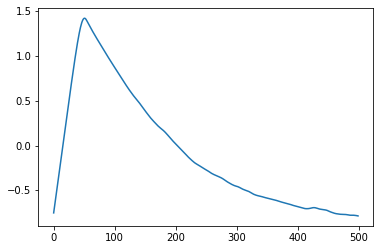

In [113]:
with torch.no_grad():
    plt.plot(barrier_nn(nn_input(x_sim)))

In [46]:
total_norm = 0.0
parameters = [
    p
    for p in control_nn.parameters()
    if p.grad is not None and p.requires_grad
]
for p in parameters:
    param_norm = p.grad.detach().data.norm(2)
    total_norm += param_norm.item() ** 2
    
print(f"u param norm: {total_norm}")

u param norm: 3.821765196369607e-05
